# DMC Example: Particle in 1D Box

We consider as a test case a particle in a 1D box. This is given by the Hamiltonian

$$
    H = -\frac{1}{2}\partial_x^2,
$$

for $x \in [0, 1]$, with homogeneous Dirichet boundary conditions. The exact ground state solution is

$$
    \psi_0(x) = \sin(\pi x),
$$

with energy

$$
    E_0 = \frac{\langle \psi_0 | H | \psi_0 \rangle}{\langle \psi_0 | \psi_0 \rangle} = \frac{\pi^2}{2} \approx 4.9348.
$$

As a trial function, we use

$$
    \psi_T(x) = x(1 - x),
$$

which has a variational energy

$$
    E_V = \frac{\langle \psi_T | H | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} = 5 > E_0.
$$

In [6]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [14]:
nconf = 100
time_step = 1e-2
reference_energy = 5
blocks = 100
steps_per_block = 10
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

Next, we create the guiding wave function:

In [15]:
class GuidingWaveFunction(WaveFunction):

    def __call__(self, x):
        y = x[0]
        return y*(1 - y)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

Next, we set up the branching algorithm and accept-reject algorithm, and construct the wave function:

In [16]:
brancher = SRBrancher()
#brancher = SimpleBrancher()
ar = DiffuseAcceptReject(fixed_node=True)
guiding_wf = GuidingWaveFunction()

And finally, initialize the DMC runner and perform diffusion Monte Carlo:

In [17]:
np.random.seed(0)
confs = [np.random.rand(1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)
es = dmc.run_dmc(time_step, blocks, steps_per_block, neq=10)

In [18]:
energy = dmc.energy_estimate[-1]
# blocking error estimate
err = np.sqrt(np.mean(es**2) - energy**2) / np.sqrt(len(es))

print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {np.pi**2/2:.5f}")

Energy: 4.93492 +/- 0.00941
Exact:  4.93480


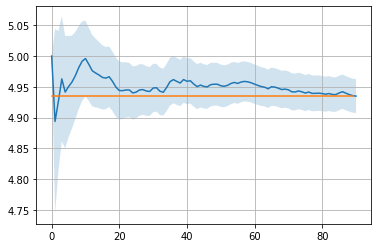

In [19]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate)
plt.fill_between(ns, dmc.energy_estimate - dmc.energy_error, dmc.energy_estimate + dmc.energy_error, alpha=0.2)

exact = np.pi**2/2                    
plt.plot([0, len(es)-1], [exact, exact])
plt.grid()
plt.show()